In [1]:
from dataset_creation import TextDataset
from torch.utils.data import DataLoader
import numpy as np

# Instantiate the dataset
text_dataset = TextDataset(directory='data/SPGC-tokens-2018-07-18/', sequence_length=100)
print(f"Dataset created with {len(text_dataset)} sequences.")

# Create a DataLoader without a sampler
dataloader = DataLoader(text_dataset, batch_size=1)

# Iterate over a few batches and print their contents
for i, (sequences, inputs) in enumerate(dataloader):
    if i >= 2:  # Adjust this value to see more/less batches
        break

    print(f"\nBatch {i+1}")
    print(f"Inputs shape: {inputs.shape}")

    # Optionally print the actual sequences (comment out if too verbose)
    sequence = ''.join([text_dataset.idx_to_char[int(idx)] for idx in inputs[0]])
    # target = text_dataset.idx_to_char[int(targets[0])]
    print(f"Sequence: {sequence}")


Dataset created with 18422222637 sequences.

Batch 1
Inputs shape: torch.Size([1, 100])
Sequence: nd start him toward home he not tell tales out of school will you old boy slapping his neck affectio

Batch 2
Inputs shape: torch.Size([1, 100])
Sequence: pe is to scream as loud as ever we can said cousin nancy nobody knows where we are the hands are all


In [2]:
import torch

# Define chars using keys of char_to_idx
chars = list(text_dataset.char_to_idx.keys())

n_characters = len(chars)  # Number of unique characters
print(f"Number of unique characters: {n_characters}")
print(f"Characters: {chars}")

Number of unique characters: 70
Characters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ',', '.', ';', "'", '"', '?', '!', ' ']


In [3]:
import torch.nn as nn

class HebbianLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(HebbianLinear, self).__init__(in_features, out_features, bias)
        self.imprints = nn.Parameter(torch.zeros_like(self.weight))

    def forward(self, input):
        # print(input)
        output = super(HebbianLinear, self).forward(input)
        self.update_imprints(input, output)
        # print(output)
        return output

    def update_imprints(self, input, output):
        # print("input shape:", input.shape)
        # print("output shape:", output.shape)
    
        # Hebbian update rule: imprint = input * output
        # Adjusting to compute the required [5, 10] imprint matrix for each batch
        # Reshape input and output for broadcasting
        input_expanded = input.unsqueeze(1)  # Shape: [batch_size, 1, in_features]
        output_expanded = output.unsqueeze(2)  # Shape: [batch_size, out_features, 1]

        # Element-wise multiplication with broadcasting
        # Results in a [batch_size, out_features, in_features] tensor
        imprint_update = output_expanded * input_expanded

        # Sum over the batch dimension to get the final imprint update
        self.imprints.data += imprint_update.sum(dim=0)



    def apply_imprints(self, reward, learning_rate):
        # Apply the imprints to the weights
        self.weight.data += reward * learning_rate * self.imprints


# Example instantiation of HebbianLinear
layer = HebbianLinear(in_features=10, out_features=5)

# Checking if the shapes are the same
print("Shape of weights:", layer.weight.shape)
print("Shape of imprints:", layer.imprints.shape)
print("Are the shapes identical?", layer.weight.shape == layer.imprints.shape)

# Generate random data
input_data = torch.randn(3, 10)  # Batch size of 3, input features 10

# Pass data through the HebbianLinear layer
output = layer(input_data)

print("Weights:\n ", layer.weight)
layer.apply_imprints(reward=0.5, learning_rate=0.1)
print("Weights after imprint:\n ", layer.weight)

Shape of weights: torch.Size([5, 10])
Shape of imprints: torch.Size([5, 10])
Are the shapes identical? True
Weights:
  Parameter containing:
tensor([[-0.1362,  0.3100, -0.1912, -0.1740,  0.2214, -0.2447, -0.0329,  0.1657,
         -0.2350,  0.3118],
        [ 0.2942, -0.1905,  0.2685, -0.2207,  0.1897,  0.0812,  0.2038,  0.0351,
         -0.1219,  0.2724],
        [ 0.2423,  0.1344, -0.2414,  0.2498, -0.0360,  0.2990,  0.0099,  0.2113,
         -0.2617,  0.2026],
        [ 0.1000, -0.2401,  0.2527,  0.3018,  0.1471,  0.1615, -0.2487, -0.2807,
         -0.1422, -0.2393],
        [-0.0257, -0.0564,  0.0087,  0.0563, -0.0513, -0.0898, -0.0462,  0.0695,
          0.1445,  0.0264]], requires_grad=True)
Weights after imprint:
  Parameter containing:
tensor([[-0.1292,  0.3548, -0.1806, -0.4283,  0.3723, -0.2174,  0.0422,  0.1164,
         -0.3205,  0.4274],
        [ 0.2977, -0.1582,  0.2759, -0.4425,  0.3106,  0.1106,  0.2718, -0.0041,
         -0.1847,  0.3910],
        [ 0.2468,  0.1247, -

In [4]:
import torch.nn.functional as F

class SimpleRNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Using HebbianLinear instead of Linear
        self.linear_layers = torch.nn.ModuleList([HebbianLinear(input_size + hidden_size, hidden_size)])
        for _ in range(1, num_layers):
            self.linear_layers.append(HebbianLinear(hidden_size, hidden_size))

        # Final layers for hidden and output, also using HebbianLinear
        self.i2h = HebbianLinear(hidden_size, hidden_size)
        self.i2o = HebbianLinear(hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), dim=1)

        # Pass through the Hebbian linear layers with ReLU
        for layer in self.linear_layers:
            combined = layer(combined)
            combined = F.relu(combined)

        # Split into hidden and output
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

    def apply_imprints(self, reward, learning_rate):
        # Apply imprints for all HebbianLinear layers
        for layer in self.linear_layers:
            layer.apply_imprints(reward, learning_rate)
        self.i2h.apply_imprints(reward, learning_rate)
        self.i2o.apply_imprints(reward, learning_rate)


# Ensure the input size matches the number of features for each input
input_size = n_characters
output_size = n_characters
n_hidden = 128
rnn = SimpleRNN(input_size, n_hidden, output_size,3)

# Define the loss function (criterion) and optimizer
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.005)



# Apply Gradient Clipping
torch.nn.utils.clip_grad_norm_(rnn.parameters(), max_norm=1.0)  # Clip gradients during training


tensor(0.)

In [5]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return text_dataset.char_to_idx[letter]

# Just for demonstration, turn a letter into a <1 x n_characters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_characters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_characters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_characters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
torch.Size([5, 1, 70])


In [6]:
text_dataset[3]

('n the convenient grapevine could he be prevented from doing this now unless the truth were told him ',
 tensor([13, 69, 19,  7,  4, 69,  2, 14, 13, 21,  4, 13,  8,  4, 13, 19, 69,  6,
         17,  0, 15,  4, 21,  8, 13,  4, 69,  2, 14, 20, 11,  3, 69,  7,  4, 69,
          1,  4, 69, 15, 17,  4, 21,  4, 13, 19,  4,  3, 69,  5, 17, 14, 12, 69,
          3, 14,  8, 13,  6, 69, 19,  7,  8, 18, 69, 13, 14, 22, 69, 20, 13, 11,
          4, 18, 18, 69, 19,  7,  4, 69, 19, 17, 20, 19,  7, 69, 22,  4, 17,  4,
         69, 19, 14, 11,  3, 69,  7,  8, 12, 69]))

In [7]:
def randomTrainingExample():
    """Generate a random training example from the dataset"""
    sequence, line_tensor = text_dataset[np.random.randint(len(text_dataset))]
    return sequence, line_tensor

randomTrainingExample()

('terpreted it and found the answer that which is written in water must be read in i understand now sa',
 tensor([19,  4, 17, 15, 17,  4, 19,  4,  3, 69,  8, 19, 69,  0, 13,  3, 69,  5,
         14, 20, 13,  3, 69, 19,  7,  4, 69,  0, 13, 18, 22,  4, 17, 69, 19,  7,
          0, 19, 69, 22,  7,  8,  2,  7, 69,  8, 18, 69, 22, 17,  8, 19, 19,  4,
         13, 69,  8, 13, 69, 22,  0, 19,  4, 17, 69, 12, 20, 18, 19, 69,  1,  4,
         69, 17,  4,  0,  3, 69,  8, 13, 69,  8, 69, 20, 13,  3,  4, 17, 18, 19,
          0, 13,  3, 69, 13, 14, 22, 69, 18,  0]))

In [8]:
learning_rate = 0.00005 # If you set this too high, it might explode. If too low, it might not learn

def train(line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(line_tensor.size()[0] - 1):
        hot_input_char_tensor = torch.nn.functional.one_hot(line_tensor[i], num_classes=n_characters).type(torch.float).unsqueeze(0)
        output, hidden = rnn(hot_input_char_tensor, hidden)

    # print("output shape:", output.shape)
    # print("line_tensor shape:", line_tensor.shape)
    # print(output)
    loss = criterion(output, line_tensor[-1].unsqueeze(0))
    # print(loss)

    # Convert loss to a reward signal
    reward = 1 / (1 + loss.item())  # Example conversion, assuming loss is non-negative

    # Apply Hebbian updates
    rnn.apply_imprints(reward, learning_rate)
    torch.nn.utils.clip_grad_norm_(rnn.parameters(),max_norm=1.0)  # Clip gradients during training

    # Perform backward pass and optimizer step if using gradient descent for other parameters
    # loss.backward()
    # optimizer.step()

    return output, loss.item()


In [9]:
import time
import math

n_iters = 100000
print_every = 50
plot_every = 10



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    sequence, line_tensor = randomTrainingExample()
    output, loss = train(line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        # Use the output to generate a character prediction
        topv, topi = output.topk(1, dim=1)  # Change dim to 1
        predicted_char = text_dataset.idx_to_char[topi[0, 0].item()]
        target_char = sequence[-1]
        correct = '✓' if predicted_char == target_char else '✗ (%s)' % target_char
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, sequence, predicted_char, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

50 0% (0m 1s) 4.3810 s close to him have i ever complained is adamo answer that the marchesa asks me you saved my life ad / I ✗ (d)
100 0% (0m 3s) nan analle eikä muille huhuna vain kerrottiin että hän olisi puuttunut kotipuolessaan vallitseviin uskon / a ✗ (n)
150 0% (0m 5s) nan is the presence or absence of fat in a cake mixture that makes the difference in the method of mixin / a ✗ (n)
200 0% (0m 6s) nan guida my beloved i understand and i promise you i do promise her head dropped on his breast her arms / a ✗ (s)
250 0% (0m 8s) nan in it news news from heaven marcus the post is come sirrah what tidings have you any letters shall i / a ✗ (i)
300 0% (0m 10s) nan  the kennel in the haymarket when one young dog who had run counter at a was found to be missing but / a ✗ (t)


KeyboardInterrupt: 

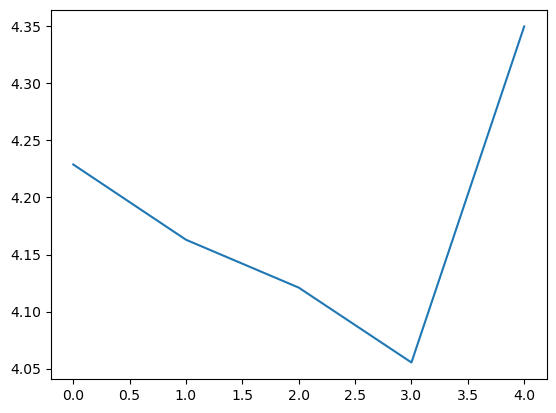

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)